In [33]:
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pyspark.pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayesModel, MultilayerPerceptronClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler

In [34]:
sc = SparkContext.getOrCreate();
spark = SparkSession(sc)

In [35]:
data = spark.read.format('csv').option("header", "True").load("./dataset/dataset.csv")

In [36]:
data.count()

17981

In [ ]:
pd.DataFrame(data.describe())

## Data Cleaning

In [5]:
data.filter(data.overall > 70).show()

23/04/24 20:55:20 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----------------+---+-----------+-------+---------+-------------------+------------------+----------------+------------+----------+-------+-------+------------+---------+--------+-----+---------+---------+------------------+---------+-----------+----------+--------------+-----------+----------------+-------------+-------+------------+----------+-------+---------+-----------+---------+-------------+----------+--------------+------------+-------+---------------+--------+------+-------+--------+-----------+
|             Name|Age|Nationality|overall|potential|               Club|Value in Thousands|Wage in Millions|Acceleration|Aggression|Agility|Balance|Ball control|Composure|Crossing|Curve|Dribbling|Finishing|Free kick accuracy|GK diving|GK handling|GK kicking|GK positioning|GK reflexes|Heading accuracy|Interceptions|Jumping|Long passing|Long shots|Marking|Penalties|Positioning|Reactions|Short passing|Shot power|Sliding tackle|Sprint speed|Stamina|Standing tackle|Strength|Vision|Volley

In [37]:
# data = data.withColumn("Wage", regexp_replace(data["Wage"], "[^0-9]+", ""))
# data = data.withColumnRenamed("Wage", "Wage in Millions")
# data = data.withColumn("Value", regexp_replace(data["Value"], "[^0-9]+", ""))
# data = data.withColumnRenamed("Value", "Value in Thousands")

# ev_udf = udf(lambda x: eval(x), IntegerType())

cols = ['Age','overall','potential','Wage in Millions', 'Value in Thousands', 'Acceleration', 'Aggression', 'Agility', 'Balance', 'Ball control', 'Composure', 'Crossing', 'Curve', 'Dribbling', 'Finishing', 'Free kick accuracy', 'GK diving', 'GK handling', 'GK kicking', 'GK positioning', 'GK reflexes', 'Heading accuracy', 'Interceptions', 'Jumping', 'Long passing', 'Long shots', 'Marking', 'Penalties', 'Positioning', 'Reactions', 'Short passing', 'Shot power', 'Sliding tackle', 'Sprint speed', 'Stamina', 'Standing tackle', 'Strength', 'Vision', 'Volleys', 'PositionNum']
for column in cols:
    # data = data.withColumn(col,ev_udf(data[col]))
    data = data.withColumn(column,data[column].cast("Integer"))

data.na.fill(value=0).show()


+-----------------+---+-----------+-------+---------+-------------------+------------------+----------------+------------+----------+-------+-------+------------+---------+--------+-----+---------+---------+------------------+---------+-----------+----------+--------------+-----------+----------------+-------------+-------+------------+----------+-------+---------+-----------+---------+-------------+----------+--------------+------------+-------+---------------+--------+------+-------+--------+-----------+
|             Name|Age|Nationality|overall|potential|               Club|Value in Thousands|Wage in Millions|Acceleration|Aggression|Agility|Balance|Ball control|Composure|Crossing|Curve|Dribbling|Finishing|Free kick accuracy|GK diving|GK handling|GK kicking|GK positioning|GK reflexes|Heading accuracy|Interceptions|Jumping|Long passing|Long shots|Marking|Penalties|Positioning|Reactions|Short passing|Shot power|Sliding tackle|Sprint speed|Stamina|Standing tackle|Strength|Vision|Volley

In [38]:
data.filter(data.overall > 70).show()

+-----------------+---+-----------+-------+---------+-------------------+------------------+----------------+------------+----------+-------+-------+------------+---------+--------+-----+---------+---------+------------------+---------+-----------+----------+--------------+-----------+----------------+-------------+-------+------------+----------+-------+---------+-----------+---------+-------------+----------+--------------+------------+-------+---------------+--------+------+-------+--------+-----------+
|             Name|Age|Nationality|overall|potential|               Club|Value in Thousands|Wage in Millions|Acceleration|Aggression|Agility|Balance|Ball control|Composure|Crossing|Curve|Dribbling|Finishing|Free kick accuracy|GK diving|GK handling|GK kicking|GK positioning|GK reflexes|Heading accuracy|Interceptions|Jumping|Long passing|Long shots|Marking|Penalties|Positioning|Reactions|Short passing|Shot power|Sliding tackle|Sprint speed|Stamina|Standing tackle|Strength|Vision|Volley

In [39]:
data.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- Club: string (nullable = true)
 |-- Value in Thousands: integer (nullable = true)
 |-- Wage in Millions: integer (nullable = true)
 |-- Acceleration: integer (nullable = true)
 |-- Aggression: integer (nullable = true)
 |-- Agility: integer (nullable = true)
 |-- Balance: integer (nullable = true)
 |-- Ball control: integer (nullable = true)
 |-- Composure: integer (nullable = true)
 |-- Crossing: integer (nullable = true)
 |-- Curve: integer (nullable = true)
 |-- Dribbling: integer (nullable = true)
 |-- Finishing: integer (nullable = true)
 |-- Free kick accuracy: integer (nullable = true)
 |-- GK diving: integer (nullable = true)
 |-- GK handling: integer (nullable = true)
 |-- GK kicking: integer (nullable = true)
 |-- GK positioning: integer (nullable = true)
 |-- GK reflexes:

### Plotting Countries with more than 500 Players

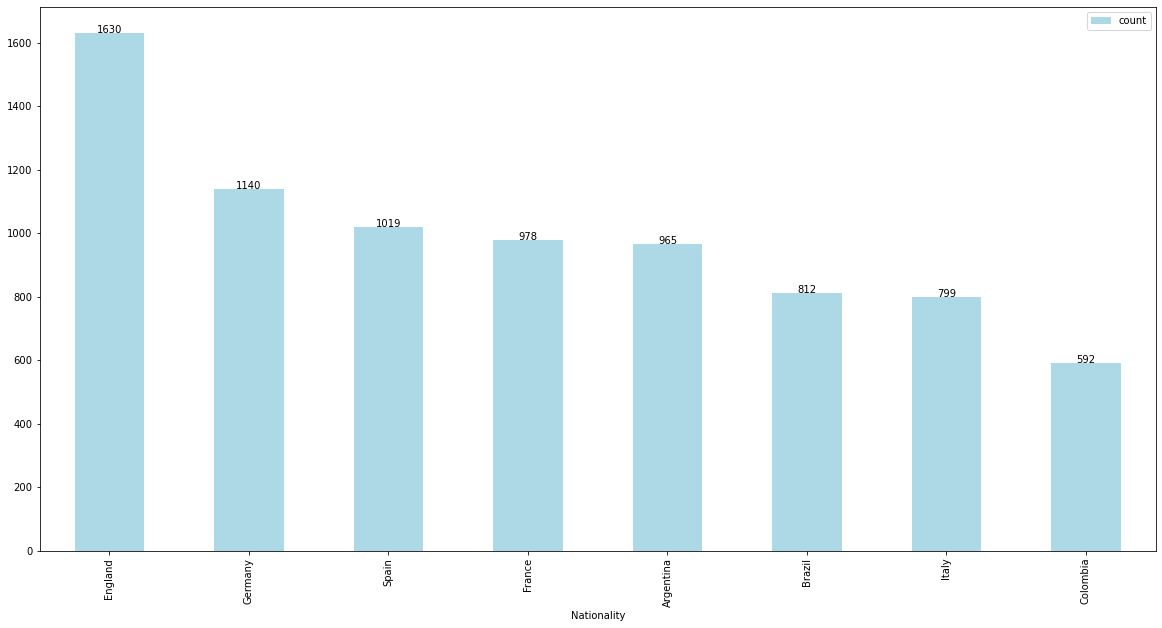

In [9]:
country_df = data.select("Nationality").groupBy("Nationality").count().sort(desc("count"))
country_df = country_df.where(country_df["count"] > 500).toPandas()
country_df.index = country_df.Nationality
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')
country_df.plot.bar(figsize=(20,10), color="lightblue")
addlabels(country_df.Nationality, country_df["count"])

### Plotting top 10 Countries with Players above 80 overall

<AxesSubplot:ylabel='Nationality'>

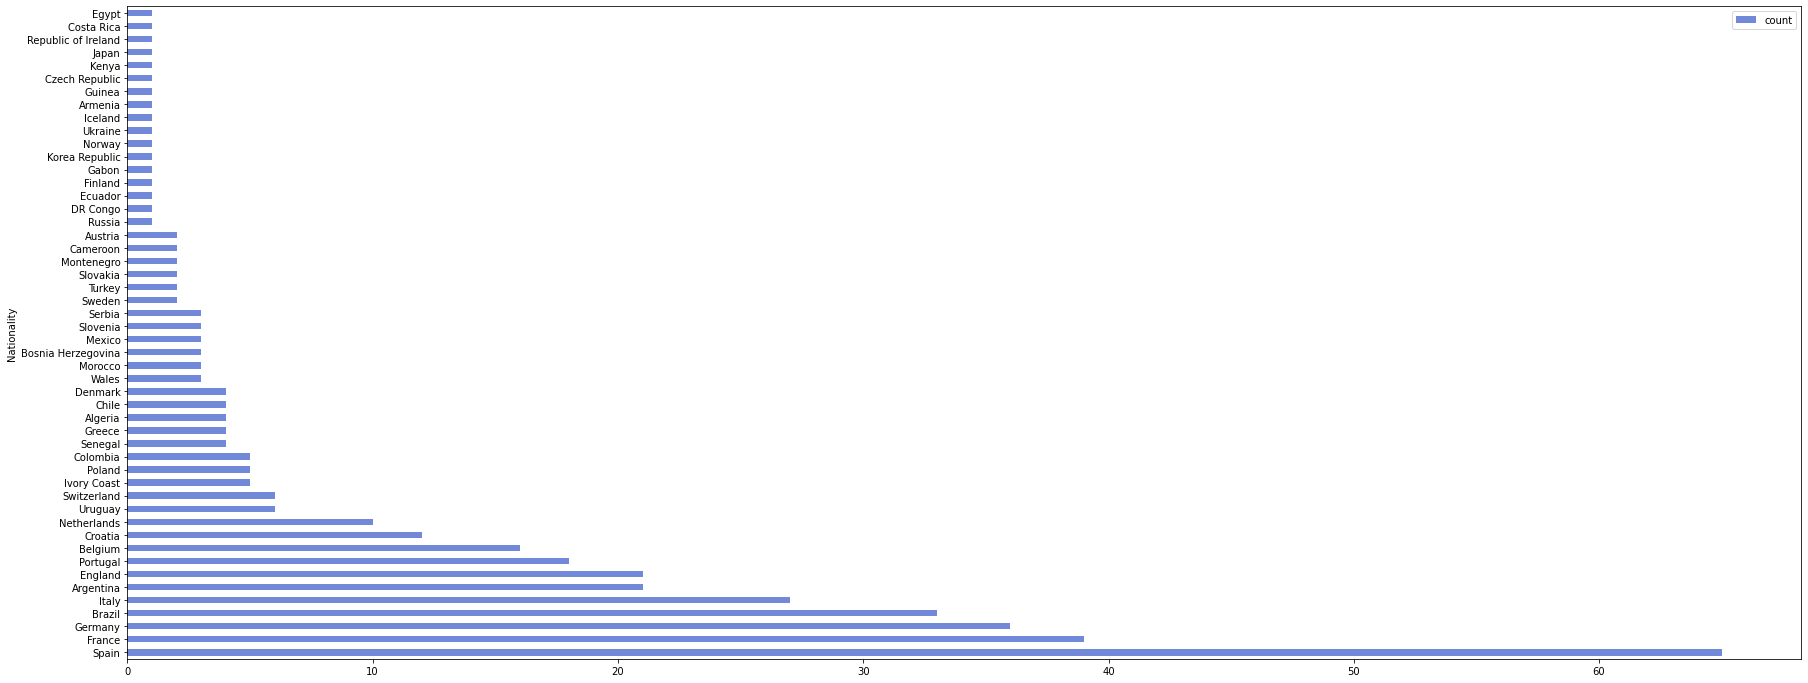

In [10]:
overall_df = data.select("Nationality", "overall").where(data["overall"] > 80).groupBy("Nationality").count().sort(desc("count")).toPandas()
overall_df.index = overall_df.Nationality
overall_df.plot.barh(figsize=(30,12), color="#7289DA")

<AxesSubplot:xlabel='Wage in Millions', ylabel='overall'>

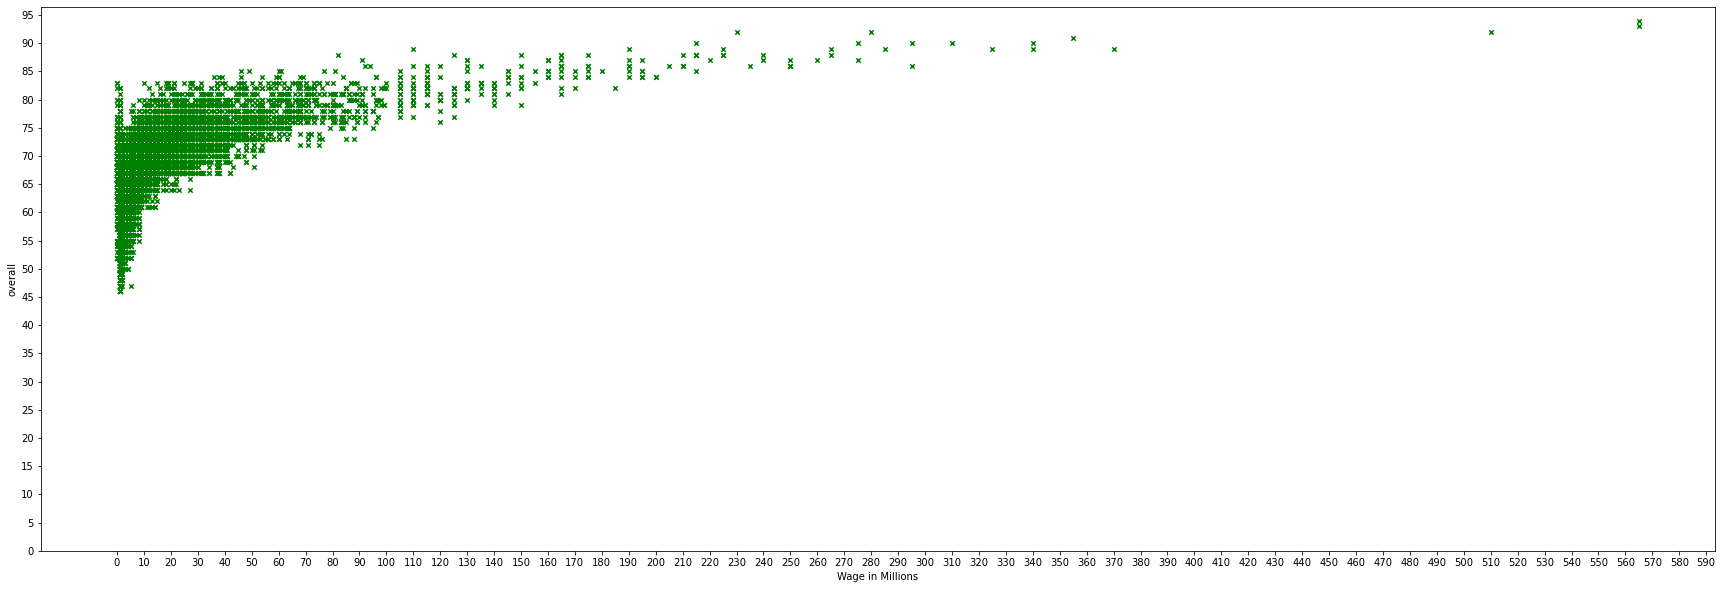

In [11]:
data.toPandas().sort_values(by=['Wage in Millions']).plot(kind="scatter",x="Wage in Millions",y="overall",figsize=(30,10), yticks=np.arange(0, 100, 5), xticks=np.arange(0,600, 10), color="green", marker='x')

In [42]:
defenders = ['LWB', 'RWB', 'CB', 'LB', 'RB']
midfielders = ['LM', 'LW', 'CM', 'RW', 'CDM']
strikers = ['CAM', 'CF', 'ST']
temp = data.where("SELECT * FROM data WHERE Position IN defenders")
temp.show()

ParseException: 
[PARSE_SYNTAX_ERROR] Syntax error at or near 'WHERE'.(line 1, pos 19)

== SQL ==
SELECT * FROM data WHERE Position IN defenders
-------------------^^^


23/04/25 00:25:32 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 631052 ms exceeds timeout 120000 ms
23/04/25 00:25:34 WARN SparkContext: Killing executors is not supported by current scheduler.
23/04/25 00:25:35 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at sc

In [19]:
data.select("Position").groupBy("Position").count().show()

+--------+-----+
|Position|count|
+--------+-----+
|     LWB|  120|
|      LM| 1326|
|     CAM| 1125|
|      LB| 1309|
|      LW|  427|
|      GK| 2029|
|      RB| 1195|
|      CM| 1977|
|      RW|  429|
|     CDM| 1396|
|      CB| 2705|
|     RWB|  111|
|      CF|  205|
|      RM| 1350|
|      ST| 2277|
+--------+-----+



<AxesSubplot:ylabel='count'>

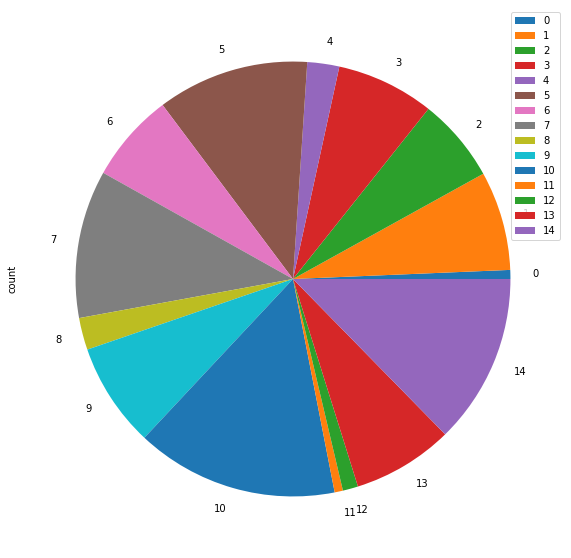

In [17]:
data.select("Position").groupBy("Position").count().toPandas().plot(kind="pie", y="count", figsize=(10,10))

## Models

In [ ]:
def modeleval(results):
    f1_score= MulticlassClassificationEvaluator(metricName='f1')
    accuracy = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="accuracy")
    accuracyResults = accuracy.evaluate(results)
    f1_scoreResults = f1_score.evaluate(results.select(col('label'), col('prediction')))
    #modelsumm=metrics.classification_report(test,results.select(col('label'), col('prediction')))
    #print("The summary of the model", modelsumm)
    print('The F1 score on the test set is {:.2%}'.format(f1_scoreResults)) 
    print("Test Error = %g" % (1.0 - accuracyResults))

In [ ]:
def predictionfunction(train, test, model):
    #logistic Regression Model
    print("Initiating Model")
    if model == 'Logistic-Regression':
        ml = LogisticRegression()
    #Random Forest Model
    elif model == 'Random-Forest':
        ml = RandomForestClassifier()
    # Gradient Boosting Model
    elif model == 'Gradient-Boost':
        ml = NaiveBayes(smoothing=1)
    else:
        return "Model not valid"
    
    print("Training Model")
    clf = ml.fit(train)
    print("Testing Model")
    results = clf.transform(test)
    modeleval(results)
    return clf, results

In [ ]:
modelData = data.select(cols)
assembler = VectorAssembler().setInputCols(modelData.columns[:-1]).setOutputCol("features")
modelData = assembler.transform(modelData)
modelData = modelData.withColumnRenamed("PositionNum", "label")

trainData = modelData.select(modelData.features, modelData.label)
trainData = trainData.withColumn("label", trainData.label.cast("Integer"))
trainData.show()

In [ ]:
(trainingData, testData) = trainData.randomSplit([0.6, 0.4], seed=123)
clf, results = predictionfunction(trainingData, testData, "Logistic-Regression")

In [ ]:

# Split the data into training and test sets
(trainingData, testData) = trainData.randomSplit([0.6, 0.4], seed=123)

# Define the layers of the neural network
layers = [39, 20, 10, 15]

print("Initiating Model")
# Create the Multilayer Perceptron Classifier with sigmoid activation
mlp = MultilayerPerceptronClassifier(maxIter=1000, layers=layers, seed=1234, labelCol="label", solver="gd")

print("Training Model")
# Train the model
model = mlp.fit(trainingData)

print("Testing Model")
# Make predictions on the test data
predictions = model.transform(testData)


In [ ]:
print("Evaluating the Model")
# Evaluate the model's performance
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="f1")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

In [ ]:
model = MultilayerPerceptronClassifier().load("./trainedModels/neuralNetwork/")

Py4JJavaError: An error occurred while calling o693.load.
: java.lang.NoSuchMethodException: org.apache.spark.ml.classification.MultilayerPerceptronClassificationModel.<init>(java.lang.String)
	at java.base/java.lang.Class.getConstructor0(Class.java:3349)
	at java.base/java.lang.Class.getConstructor(Class.java:2151)
	at org.apache.spark.ml.util.DefaultParamsReader.load(ReadWrite.scala:468)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)


23/04/22 20:50:28 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 653950 ms exceeds timeout 120000 ms
23/04/22 20:50:30 WARN SparkContext: Killing executors is not supported by current scheduler.
23/04/22 20:50:33 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.B